In [1]:
setwd(paste0(Sys.getenv('R_SOURCES'), '/house_prices'))
getwd()

[1] "/mnt/hdd/develop/kaggle/R_sources/house_prices"

In [3]:
source('main.R')
house_prices$helpers$import_libs()

combined_dataset <- house_prices$helpers$load_data()
training_dataset <- combined_dataset %>% filter(dataSource == 'train')

test_that("...", {    
    strange_cases <- house_prices$outliers$get_strange_cases(combined_dataset)
    combined_dataset_cleared <- house_prices$outliers$remove_outliers(combined_dataset)
    
    strange_cases2 <- house_prices$outliers$get_strange_cases(combined_dataset)
    training_dataset_cleared <- house_prices$outliers$remove_outliers(training_dataset)

    expect_equal(nrow(strange_cases) + nrow(combined_dataset_cleared), nrow(combined_dataset))
    expect_equal(nrow(strange_cases2) + nrow(training_dataset_cleared), nrow(training_dataset))
    expect_equal(strange_cases, strange_cases2)
})

In [41]:
training_dataset <- 
    training_dataset %>%
    mutate(
        quality = case_when(
            OverallQual %in% c(1, 2, 3) ~ 'Bad',
            OverallQual %in% c(4, 5, 6) ~ 'Fair',
            OverallQual %in% c(7, 8)    ~ 'Good',
            TRUE                        ~ 'Excellent'
        ),
        price_per_sq = SalePrice / GrLivArea
    ) %>%
    group_by(Neighborhood) %>%
    mutate(
        SPDANM = SalePrice - median(SalePrice)
    )

strange_cases <- house_prices$outliers$get_strange_cases(training_dataset)

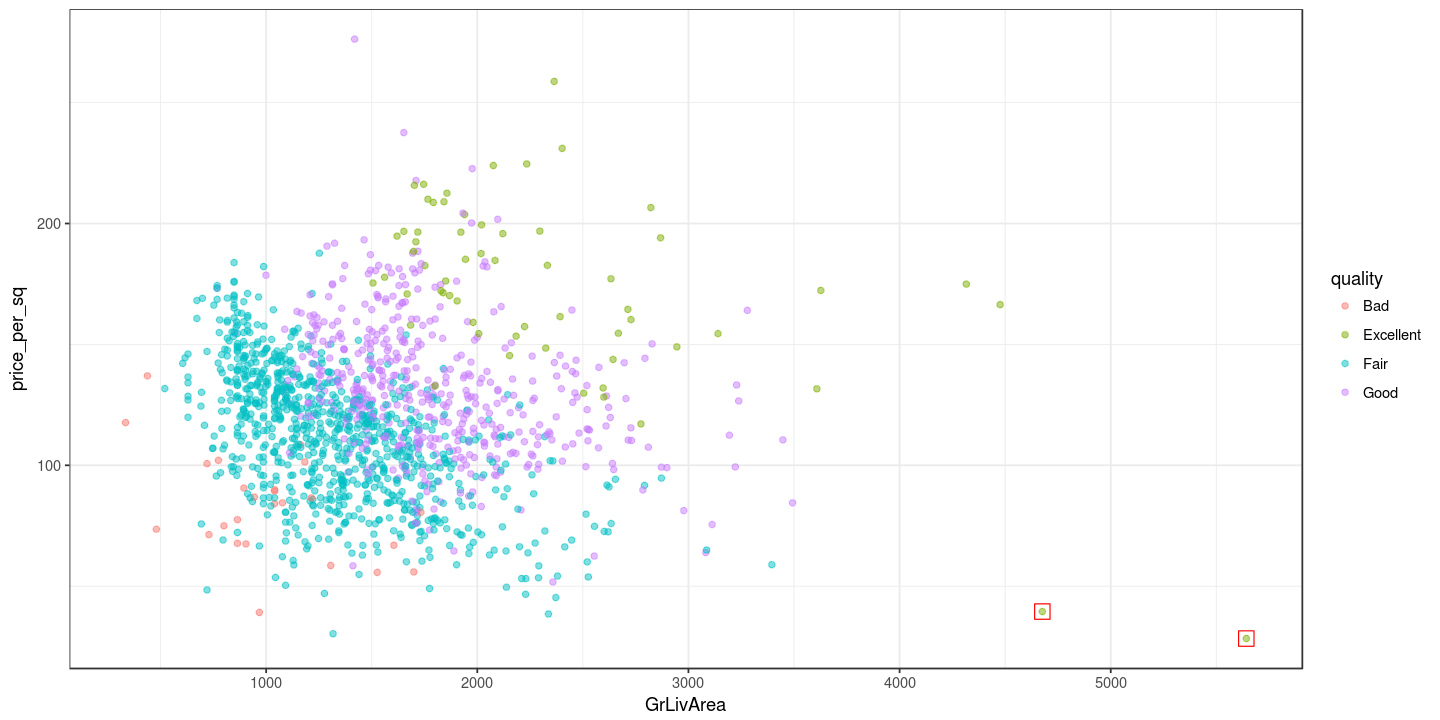

In [42]:
options(repr.plot.width = 12, repr.plot.height = 6)

training_dataset %>%
ggplot() +
geom_point(aes(x=GrLivArea, y=price_per_sq, color=quality), alpha=0.5) +
geom_point(data=strange_cases, aes(x=GrLivArea, y=price_per_sq), colour="red", size=4, shape=0) +
theme_bw()

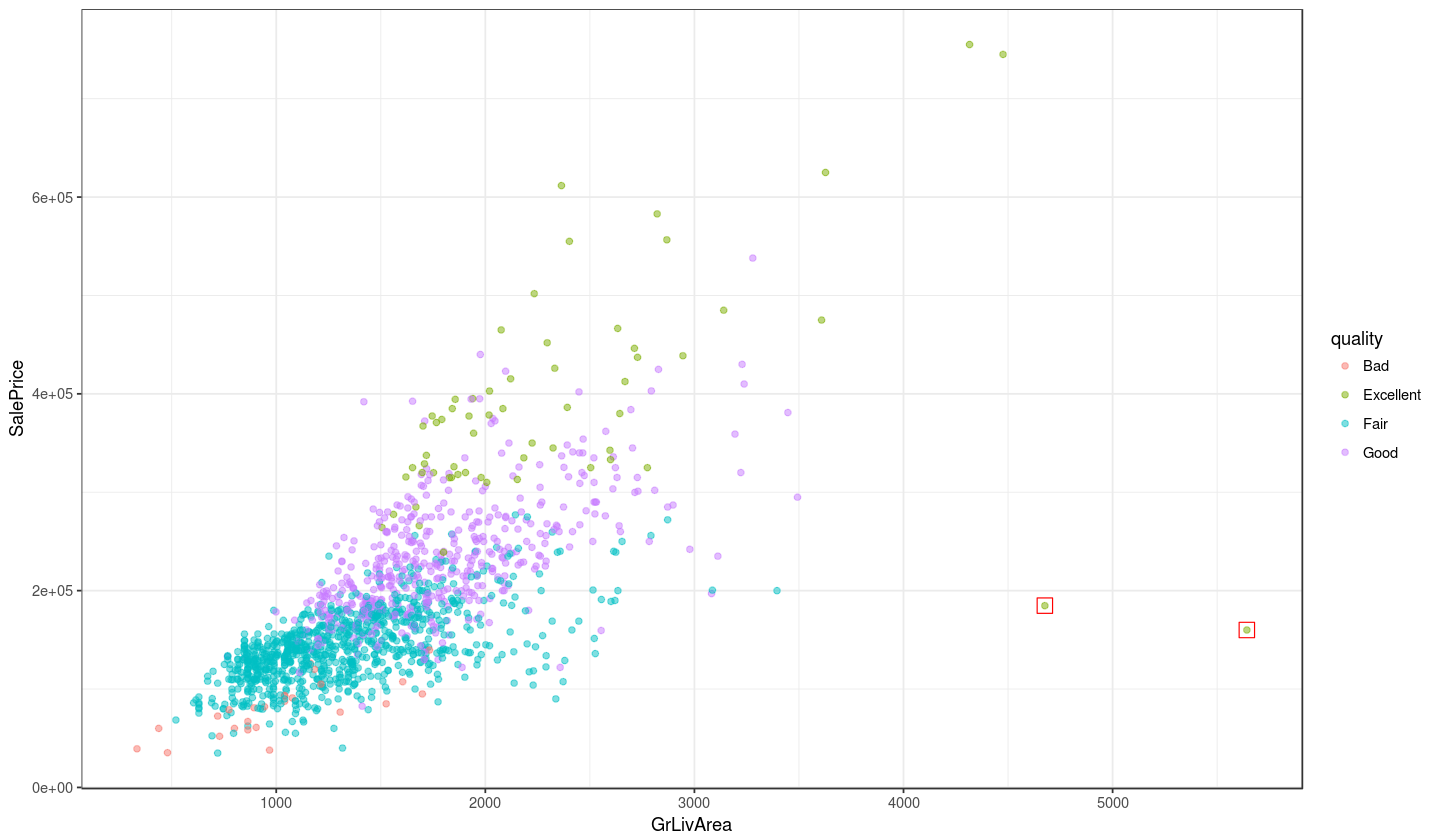

In [43]:
options(repr.plot.width = 12, repr.plot.height = 7)

training_dataset %>%
ggplot() +
geom_point(aes(x=GrLivArea, y=SalePrice, color=quality), alpha=0.5) +
geom_point(data=strange_cases, aes(x=GrLivArea, y=SalePrice), colour="red", size=4, shape=0) +
theme_bw()

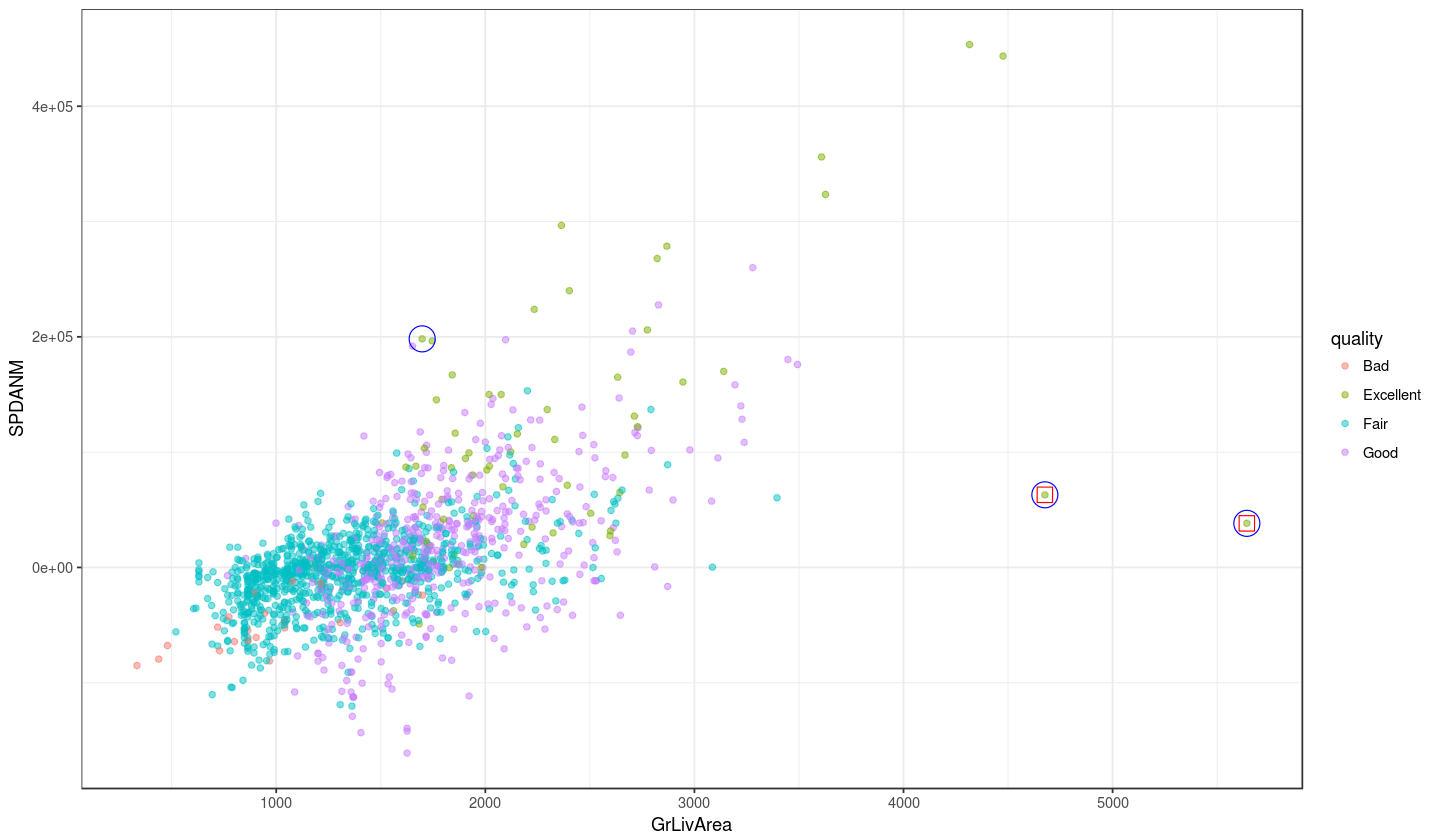

In [44]:
options(repr.plot.width = 12, repr.plot.height = 7)

training_dataset %>%
ggplot() +
geom_point(aes(x=GrLivArea, y=SPDANM, color=quality), alpha=0.5) +
geom_point(data=strange_cases, aes(x=GrLivArea, y=SPDANM), colour="red", size=4, shape=0) +
geom_point(
    data=training_dataset %>% filter(Neighborhood == 'Edwards', quality == 'Excellent'), 
    aes(x=GrLivArea, y=SPDANM), colour="blue", size=7, shape=1) +
theme_bw()

In [45]:
training_dataset %>% 
group_by(Neighborhood) %>%
summarise(
    median = median(SalePrice),
    n = n()
) %>%
arrange(median) %>%
head(10)

Neighborhood,median,n
MeadowV,88000,17
IDOTRR,103000,37
BrDale,106000,16
OldTown,119000,113
Edwards,121750,100
BrkSide,124300,58
Sawyer,135000,74
Blueste,137500,2
SWISU,139500,25
NAmes,140000,225


In [46]:
strange_cases %>%
filter(quality == 'Excellent') %>%
select(quality, Neighborhood, SalePrice)

training_dataset %>%
filter(Neighborhood == 'Edwards') %>%
group_by(quality) %>%
summarise(
    median = median(SalePrice),
    n = n()
)

quality,Neighborhood,SalePrice
Excellent,Edwards,184750
Excellent,Edwards,160000


quality,median,n
Bad,73000,6
Excellent,184750,3
Fair,119000,86
Good,137500,5


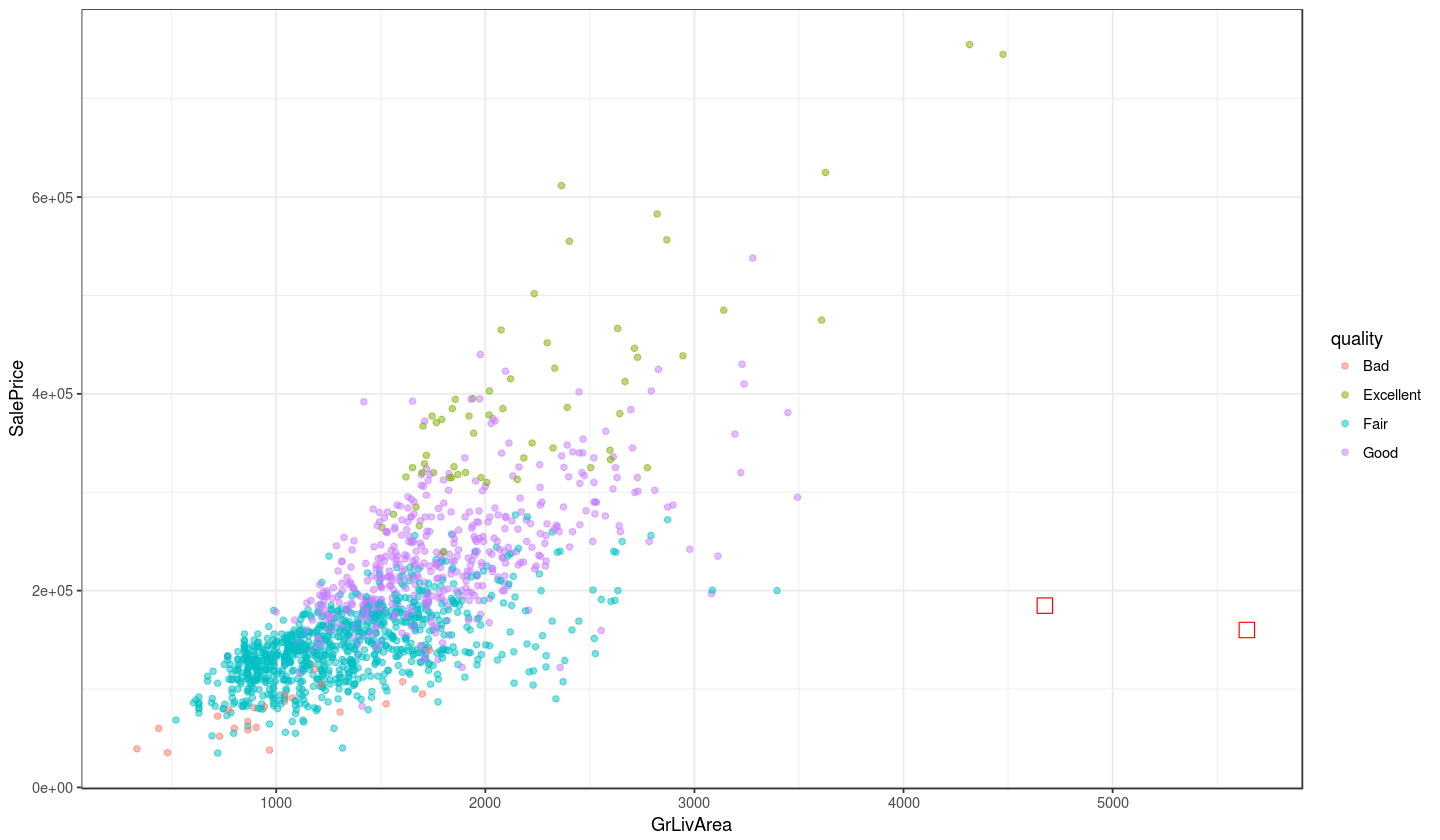

In [48]:
options(repr.plot.width = 12, repr.plot.height = 7)

training_dataset %>%
(house_prices$outliers$remove_outliers) %>%
ggplot() +
geom_point(aes(x=GrLivArea, y=SalePrice, color=quality), alpha=0.5) +
geom_point(data=strange_cases, aes(x=GrLivArea, y=SalePrice), colour="red", size=4, shape=0) +
theme_bw()